<h1>Capstone Project #1</h1>
<h2>Predicting Customer Churn</h2>
<h3>Cliff Robbins</h3>

<h3>Proposal</h3>
<p>My project will focus on a problem that 28 million business face each day of operation, customer churn.</p>

<h3>Description:</h3>
<p><strong>Customer churn</strong>, also known as customer attrition, customer turnover or customer defection is the loss of clients or customers.  Many companies include customer churn rate as part of their monitoring metrics because the cost of retaining current customers compared to acquiring new customers is much less.  
Within customer churn there is the concept of voluntary and involuntary churn with voluntary being a customer leaves on their own choice while involuntary could be attributed to customer relocation to a long term care facility, death or customer relocation in a different state/geography.  In most analytical models, involuntary churn is excluded from the metric.
</p>

<h3>Formulation of a Question</h3>
<p>When a company first starts up, the founding members can typically handle all of the various customer concerns.  As the company continues to grow, the founders can no longer service all of the various clients with support handled by a customer service team.  The customer service team focuses on current issues and a proactive approach is lost.</p>
<p>As the company grows, the company still cares about its clients; however, due to the large customer base they can no longer address each and every customer.  This is a real problem for companies.  How does a company proactively predict if a customer is happy or unhappy?  How does a company know if a customer is so unhappy that they are willing to leave?  If a company knew if a customer was getting ready to leave, could they reach out to the customer and mend the relationship?</p>
<h3>Hypothesis</h3>
<p>I believe past customer data can predict future customer churn. </p>
<h3>Prediction</h3>
<p>If I had past customer data that showed various features and whether they stayed or churned we could use that data to predict future outcomes of current customers.</p>
<h3>Testing</h3>
<p>To test my hypothesis, I will use a set of customer data with various features along with whether they churned or not.</p>
<p>The data has 7043 rows and can be found at:</p>
<p>https://www.kaggle.com/blastchar/telco-customer-churn</p>

<h2>Machine Learning</h2>
I will use various machine learning techniques to try and predict the correct outcome.<br>
To predict the outcome, I will use classification techniques.

In [84]:
%matplotlib inline
import pandas as pd
import numpy as np
import scipy as sp
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
import sklearn.model_selection
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)


def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = sklearn.model_selection.GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print("BEST PARAMS", gs.best_params_)
    best = gs.best_estimator_
    return best

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.75,test_size=0.25):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size, test_size=test_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print("Accuracy on training data: {:0.12f}".format(training_accuracy))
    print("Accuracy on test data:     {:0.12f}".format(test_accuracy))
    return clf, Xtrain, ytrain, Xtest, ytest

<h2>Import the data from our previous notebook</h2>

In [85]:
#Lets import the data
customer_churn_df = pd.read_hdf('data/cp1-2-assigned-data.hdf5',key='cleaned_data',mode='r')

#Validate it was read
print(customer_churn_df.info())

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 8 columns):
SeniorCitizen       7043 non-null category
Partner             7043 non-null category
Dependents          7043 non-null category
InternetService     7043 non-null category
Contract            7043 non-null category
PaperlessBilling    7043 non-null category
PaymentMethod       7043 non-null category
Churn               7043 non-null category
dtypes: category(8)
memory usage: 110.9+ KB
None


<h2>Convert string to numerical</h2>
The fit method requires a numerical number versus a string.

In [86]:
for column in customer_churn_df.columns:
    if customer_churn_df[column].dtype == 'category':
        le = preprocessing.LabelEncoder()
        customer_churn_df[column] = le.fit_transform(customer_churn_df[column])
        
print(customer_churn_df.info())
print(customer_churn_df.head())

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 8 columns):
SeniorCitizen       7043 non-null int64
Partner             7043 non-null int64
Dependents          7043 non-null int64
InternetService     7043 non-null int64
Contract            7043 non-null int64
PaperlessBilling    7043 non-null int64
PaymentMethod       7043 non-null int64
Churn               7043 non-null int64
dtypes: int64(8)
memory usage: 495.2+ KB
None
            SeniorCitizen  Partner  Dependents  InternetService  Contract  PaperlessBilling  PaymentMethod  Churn
customerID                                                                                                       
7590-VHVEG              0        1           0                0         0                 1              2      0
5575-GNVDE              0        0           0                0         1                 0              3      0
3668-QPYBK              0        0           0                

<h2>Training and Test Datasets</h2>
I start with a basic Logistic Regression with L1 and L2 optimization.<br>
I will split with a 75/25 split for test and training datasets.

In [109]:
features = ['SeniorCitizen','Partner','Dependents','InternetService','Contract','PaperlessBilling','PaymentMethod']
parameters = {'C':[0.001,0.01, 0.1, 1, 10, 100]}

# Split the data into a training and test set.
Xlr, Xtestlr, ylr, ytestlr = train_test_split(customer_churn_df[features].values, 
                                              (customer_churn_df.Churn == 1).values,random_state=5,stratify=(customer_churn_df.Churn == 1).values)

clf_l1 = LogisticRegression(penalty='l1')
clf_l1.fit(Xlr,ylr)

clf_l2 = LogisticRegression(penalty='l2')
clf_l2.fit(Xlr,ylr)

# Fit the model on the trainng data.
gs_l1 = sklearn.model_selection.GridSearchCV(clf_l1, param_grid=parameters, cv=5,refit=True)
gs_l1.fit(Xlr, ylr)
y_pred_l1 = gs_l1.predict(Xtestlr)
print("Best Params l1:: ", gs_l1.best_params_)

gs_l2 = sklearn.model_selection.GridSearchCV(clf_l2, param_grid=parameters, cv=5,refit=True)
gs_l2.fit(Xlr, ylr)
y_pred_l2 = gs_l2.predict(Xtestlr)

print("Best Params l2:: ", gs_l2.best_params_)
print()
# Print the accuracy from the testing data.
print('Accuracy of l1:: ',accuracy_score(clf_l1.predict(Xtestlr), ytestlr))
print('Accuracy of l2:: ',accuracy_score(clf_l2.predict(Xtestlr), ytestlr))
print()
print('Accuracy of l1 w/C Param:: ',accuracy_score(gs_l1.predict(Xtestlr), ytestlr))
print('Accuracy of l2 w/C Param:: ',accuracy_score(gs_l2.predict(Xtestlr), ytestlr))
print()
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(gs_l1.score(Xtestlr, ytestlr)))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(gs_l2.score(Xtestlr, ytestlr)))

Best Params l1::  {'C': 0.1}
Best Params l2::  {'C': 0.01}

Accuracy of l1::  0.747870528109029
Accuracy of l2::  0.747870528109029

Accuracy of l1 w/C Param::  0.7535491198182851
Accuracy of l2 w/C Param::  0.7438955139125497

Accuracy of logistic regression classifier on test set: 0.75
Accuracy of logistic regression classifier on test set: 0.74


<h2>Additional Parameter Testing</h2>
Now I'll do additional testing against the training and test data.

In [110]:
#Lets test to see if we have the best parameters
print('Logistic Regression with L1')
clf_l, Xtrain_l, ytrain_l, Xtest_l, ytest_l  = do_classify(LogisticRegression(penalty='l1'), 
                                                           {"C": [0.001,0.01, 0.1, 1, 10, 100]}, 
                                                           customer_churn_df, features, 'Churn',1)
print()
print('Logistic Regression with L2')
clf_2, Xtrain_2, ytrain_2, Xtest_2, ytest_2  = do_classify(LogisticRegression(penalty='l2'), 
                                                           {"C": [0.001,0.01, 0.1, 1, 10, 100]}, 
                                                           customer_churn_df, features, 'Churn',1)

Logistic Regression with L1
BEST PARAMS {'C': 0.1}
Accuracy on training data: 0.751419916698
Accuracy on test data:     0.743327654742

Logistic Regression with L2
BEST PARAMS {'C': 0.01}
Accuracy on training data: 0.751041272245
Accuracy on test data:     0.733674048836


<h2>Confusion Matrix</h2>
The ideal scenario that we all want is that the model should give 0 False Positives and 0 False Negatives. But that’s not the case in real life as any model will NOT be 100% accurate most of the times.<br>
<strong>1. True Positives (TP):</strong> True positives are the cases when the actual class of the data point was 1(True) and the predicted is also 1(True)<br>
<strong>2.  True Negatives (TN):</strong> True negatives are the cases when the actual class of the data point was 0(False) and the predicted is also 0(False)<br>
<strong>3.  False Positives (FP):</strong> False positives are the cases when the actual class of the data point was 0(False) and the predicted is 1(True). False is because the model has predicted incorrectly and positive because the class predicted was a positive one. (1)<br>
<strong>4.  False Negatives (FN):</strong> False negatives are the cases when the actual class of the data point was 1(True) and the predicted is 0(False). False is because the model has predicted incorrectly and negative because the class predicted was a negative one. (0)<br><br>
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html<br>
https://medium.com/greyatom/performance-metrics-for-classification-problems-in-machine-learning-part-i-b085d432082b


In [111]:
confusion_matrix_l1 = confusion_matrix(ytestlr, y_pred_l1)
confusion_matrix_l2 = confusion_matrix(ytestlr, y_pred_l2)
# ref https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

print('                  l1 Confusion Matrix')
print('')
print('                            Actual        ')
print('                    Positives     Negatives')
print('                     ----------+-----------')
print('Predicted')
print('          Positives    (TP)'+str(confusion_matrix_l1[1][1])+'     (FP)'+str(confusion_matrix_l1[0][1]))
print('                     ----------+-----------)')
print('')
print('          Negatives    (FN)'+str(confusion_matrix_l1[1][0])+'    (TN)'+str(confusion_matrix_l1[0][0]))
print('')
print('                     ----------+-----------)')
print('')
print('')
print('                  l2 Confusion Matrix')
print('')
print('                            Actual        ')
print('                    Positives     Negatives')
print('                     ----------+-----------')
print('Predicted')
print('          Positives    (TP)'+str(confusion_matrix_l2[1][1])+'     (FP)'+str(confusion_matrix_l2[0][1]))
print('                     ----------+-----------)')
print('')
print('          Negatives    (FN)'+str(confusion_matrix_l2[1][0])+'    (TN)'+str(confusion_matrix_l2[0][0]))
print('')
print('                     ----------+-----------)')



                  l1 Confusion Matrix

                            Actual        
                    Positives     Negatives
                     ----------+-----------
Predicted
          Positives    (TP)89     (FP)56
                     ----------+-----------)

          Negatives    (FN)378    (TN)1238

                     ----------+-----------)


                  l2 Confusion Matrix

                            Actual        
                    Positives     Negatives
                     ----------+-----------
Predicted
          Positives    (TP)50     (FP)34
                     ----------+-----------)

          Negatives    (FN)417    (TN)1260

                     ----------+-----------)


Because of the nature of the project, trying to predict customer churn, we would want to minimize False Negatives (FN) because our goal is to find ways to keep those that might churn.  That means we may provide additional incentives to those that are likely to stay anyway.

<h2>Accuracy</h2><br>
<strong>Precision</strong> is a measure that tells us what proportion of customers that we predicted as churning, actually churned. The predicted positives (People predicted as churned are TP and FP) and the people actually churned are TP.<br>
<strong>Recall</strong> is a measure that tells us what proportion of customers that actually churned was predicted by the algorithm as churned.<br>
<strong>F1 Score</strong>  We don’t really want to carry both Precision and Recall in our pockets every time we make a model for solving a classification problem. So it’s best if we can get a single score that kind of represents both Precision(P) and Recall(R).<br>
One way to do that is simply taking their arithmetic mean. i.e (P + R) / 2 where P is Precision and R is Recall.
<h3>When to use Precison and when to use Recall?</h3>
It is clear that recall gives us information about a classifier’s performance with respect to false negatives (how many did we miss), while precision gives us information about its performance with respect to false positives(how many did we caught).<br>
<strong>Precision</strong> is about being precise. So even if we managed to capture only one churn, and we captured it correctly, then we are 100% precise.<br>
<strong>Recall</strong> is not so much about capturing customers correctly but more about capturing all customers that have churned with the answer as churn. So if we simply always say every customer as churned, we have 100% recall.<br><br>
So basically if we want to focus more on minimising False Negatives, we would want our Recall to be as close to 100% as possible without precision being too bad and if we want to focus on minimising False positives, then our focus should be to make Precision as close to 100% as possible.
<br><br>
https://medium.com/greyatom/performance-metrics-for-classification-problems-in-machine-learning-part-i-b085d432082b

In [112]:
from sklearn.metrics import classification_report
# ref: http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html#sklearn.metrics.classification_report

print("l1 Training Classification Report:")
print(classification_report(ylr, ytrain_l))
print('\n')
print("l1 Test Classification Report:")
print(classification_report(ytestlr, ytest_l))
print('\n')
print('\n')
print("l2 Training Classification Report:")
print(classification_report(ylr, ytrain_2))
print('\n')
print("l2 Test Classification Report:")
print(classification_report(ytestlr, ytest_2))

l1 Training Classification Report:
             precision    recall  f1-score   support

      False       0.74      0.74      0.74      3880
       True       0.27      0.27      0.27      1402

avg / total       0.61      0.61      0.61      5282



l1 Test Classification Report:
             precision    recall  f1-score   support

      False       0.73      0.73      0.73      1294
       True       0.24      0.24      0.24       467

avg / total       0.60      0.60      0.60      1761





l2 Training Classification Report:
             precision    recall  f1-score   support

      False       0.74      0.74      0.74      3880
       True       0.27      0.27      0.27      1402

avg / total       0.61      0.61      0.61      5282



l2 Test Classification Report:
             precision    recall  f1-score   support

      False       0.73      0.72      0.73      1294
       True       0.26      0.27      0.27       467

avg / total       0.61      0.60      0.61      1761



From what we can see, the training performance metrics are slightly better than the test counterpart.  However, we can make note that the prediction for False has a higher accuracy than True.

<h2>ROC Curve</h2>
The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).<br>
This is based on: https://towardsdatascience.com/building-a-logistic-regression-in-python-step-by-step-becd4d56c9c8

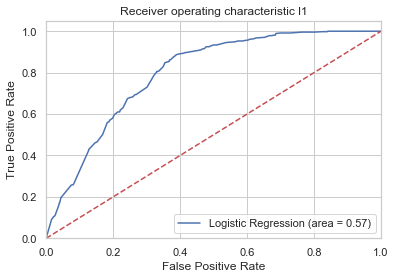

In [113]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(ytestlr, gs_l1.predict(Xtestlr))
fpr, tpr, thresholds = roc_curve(ytestlr, gs_l1.predict_proba(Xtestlr)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic l1')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

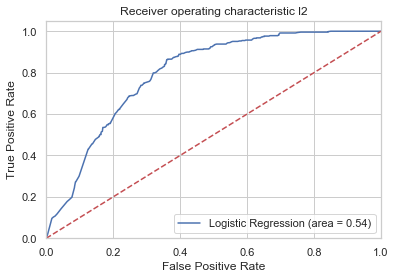

In [114]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
logit_roc_auc = roc_auc_score(ytestlr, gs_l2.predict(Xtestlr))
fpr, tpr, thresholds = roc_curve(ytestlr, gs_l2.predict_proba(Xtestlr)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic l2')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()

<h2>Analysis</h2><br>
This analysis used a basic logistic regression with l1 and l2 optimization as the baseline model.<br>
The accuracy score for the l1 is slightly better than with l2 optimization.<br><br>
Logistic Regression with L1<br>
Accuracy Score on training data: 0.751798561151<br>
Accuracy Score on test data:     0.741624077229<br>
<br>
Logistic Regression with L2<br>
Accuracy Score on training data: 0.744793638773<br>
Accuracy Score on test data:     0.749574105622<br>
<br>
With both l1 and l2, we can see that the model fits the training and test data.  The fit of the test data is slightly less accurate than the training data as we would expect.<br>
<br>
When we compare classification reports, the data shows that the model fits well for the False and fits less for the True.  The overall accuracy, recall and F1 scores are roughly 0.61.<br>

<table style="width:100%">
    <caption>l1 Training Classification Report:</caption>
  <tr>
      <th>Label</th>
    <th>precision</th>
    <th>recall</th> 
    <th>f1-score</th>
  </tr>
  <tr>
      <td>False</td>
    <td>0.73</td>
    <td>0.73</td> 
    <td>0.73</td>
  </tr>
  <tr>
      <td>True</td>
    <td>0.26</td>
    <td>0.26</td> 
    <td>0.26</td>
  </tr>
    
  <tr>
      <td>avg / total</td>
    <td>0.61</td>
    <td>0.61</td> 
    <td>0.61</td>
  </tr>
</table>

<br>
<table style="width:100%">
    <caption>l2 Training Classification Report:</caption>
  <tr>
      <th>Label</th>
    <th>precision</th>
    <th>recall</th> 
    <th>f1-score</th>
  </tr>
  <tr>
      <td>False</td>
    <td>0.74</td>
    <td>0.73</td> 
    <td>0.73</td>
  </tr>
  <tr>
      <td>True</td>
    <td>0.26</td>
    <td>0.27</td> 
    <td>0.27</td>
  </tr>
    
  <tr>
      <td>avg / total</td>
    <td>0.61</td>
    <td>0.61</td> 
    <td>0.61</td>
  </tr>
</table>


Overall, the model has a adequate accuracy score of 0.75 with precision, recall and F1 scores of 0.61.  The model performance could get improved to provide a higher accuracy score and an improved classification report.
